In [59]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
from datetime import datetime as dt
from copy import deepcopy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from scipy import stats
from sklearn import preprocessing
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import average_precision_score, recall_score, f1_score
from kneed import DataGenerator, KneeLocator
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from orion.contrib.envs import load_env
#load_env()
import boto3

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from orion.sources import S3Source
aws_bucket = 'kilimanjaro-prod-datalake'
s3 = boto3.client('s3')

In [6]:
cust_summary = cust_summary[['customerkey','orders','total_unitssold','total_grosssales','days_bw_orders','ASP','loyaltyaccount','gender', 'shipcountry','postcode','latitude','longitude' ,'category','divisioncode','productgroup','brandcode']]

In [8]:
cust_summary = pd.read_csv('cust_summary.csv', index_col=0)

In [9]:
cust_summary.isnull().sum()

customerkey         0
orders              0
total_unitssold     0
total_grosssales    0
days_bw_orders      0
ASP                 0
loyaltyaccount      0
gender              0
shipcountry         0
postcode            0
category            0
divisioncode        0
productgroup        0
brandcode           0
latitude            0
longitude           0
dtype: int64

In [10]:
cont_custsum = cust_summary[['orders','total_unitssold','total_grosssales','days_bw_orders','ASP','latitude','longitude']]

In [11]:
from io import StringIO  
csv_buffer = StringIO()
cont_custsum.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object('kilimanjaro-prod-datalake','masters/datascience/emma/cont_custsum.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'YYWP50AF9Y1K9V29',
  'HostId': '9Lc6kqXAV+dQfV/ovZsh0ClCPI2r7LCOoU57pXYPPh+Sa4xu57yyj33e/11Y02+6P61LnjK69eo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '9Lc6kqXAV+dQfV/ovZsh0ClCPI2r7LCOoU57pXYPPh+Sa4xu57yyj33e/11Y02+6P61LnjK69eo=',
   'x-amz-request-id': 'YYWP50AF9Y1K9V29',
   'date': 'Mon, 05 Jul 2021 14:09:28 GMT',
   'x-amz-version-id': 'oDtdqSCP5CNZb8OXnmeJfeiV2xs5eUui',
   'x-amz-server-side-encryption': 'aws:kms',
   'x-amz-server-side-encryption-aws-kms-key-id': 'arn:aws:kms:eu-west-1:794236216820:key/68512d48-1991-4929-91a2-1892476cd145',
   'etag': '"6679f49b96cb9b74eb841454c6e0e880"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 1},
 'ETag': '"6679f49b96cb9b74eb841454c6e0e880"',
 'ServerSideEncryption': 'aws:kms',
 'VersionId': 'oDtdqSCP5CNZb8OXnmeJfeiV2xs5eUui',
 'SSEKMSKeyId': 'arn:aws:kms:eu-west-1:794236216820:key/68512d48-1991-4929-91a2-1892476cd145'}

In [24]:
cust_summary['orders'].describe().round(2)

count    2204873.00
mean           1.51
std            1.31
min            1.00
25%            1.00
50%            1.00
75%            2.00
max          256.00
Name: orders, dtype: float64

In [12]:
cut_labels_4 = ['1', '2-5', '6-20', '20+']
cut_bins = [0, 1, 5, 20, 256]
cust_summary['orders_1'] = pd.cut(cust_summary['orders'], bins=cut_bins, labels=cut_labels_4)

In [13]:
cust_summary.head()

,customerkey,orders,total_unitssold,total_grosssales,days_bw_orders,ASP,loyaltyaccount,gender,shipcountry,postcode,category,divisioncode,productgroup,brandcode,latitude,longitude,orders_1
0,fb484d6a54da0d56910e2df0064c18c722801a66,256,603,35645.08,4,61.44,Yes,female,United Kingdom,TW9,Junior,FOOTWEAR,Basketball,AA,51.4728,-0.296367,20+
1,649cca818138ed8152825855e0538ed7360bd55a,152,400,18320.26,9,51.97,Yes,female,United Kingdom,DL5,Mens,APPAREL,Nylon Running,NN,54.6000,-1.587800,20+
2,559aec727d6d73e55e476a34a374f1fb26dc06cf,152,401,16730.55,7,44.44,Yes,female,United Kingdom,LL18,Mens,FOOTWEAR,Vulcanised,NN,53.2910,-3.454820,20+
3,35d17f77612459a698d0179b7525c6eedacc6fd6,144,469,15046.12,8,37.51,Yes,female,United Kingdom,N19,Mens,APPAREL,T-shirts,KWD,51.5649,-0.135100,20+
4,67f9aeeef82eefa706b6886df0b790992e3b5a61,114,225,11631.89,11,63.97,Yes,male,United Kingdom,WA1,Womens,FOOTWEAR,Nylon Running,AA,53.3925,-2.561000,20+


In [32]:
pd.cut(cust_summary['orders'], bins=6).value_counts()

(0.745, 43.5]     2204833
(43.5, 86.0]           27
(86.0, 128.5]           9
(128.5, 171.0]          3
(213.5, 256.0]          1
(171.0, 213.5]          0
Name: orders, dtype: int64

In [25]:
cust_summary['total_unitssold'].describe().round(2)

count    2204873.00
mean           4.98
std            6.34
min           -1.00
25%            2.00
50%            4.00
75%            6.00
max          603.00
Name: total_unitssold, dtype: float64

In [26]:
cust_summary['total_grosssales'].describe().round(2)

count    2204873.00
mean         193.04
std          238.96
min            0.22
25%           75.41
50%          126.99
75%          218.37
max        35645.08
Name: total_grosssales, dtype: float64

In [27]:
cust_summary['days_bw_orders'].describe().round(2)

count    2204873.00
mean        1407.43
std          709.78
min            1.00
25%          744.00
50%         1825.00
75%         1825.00
max         1825.00
Name: days_bw_orders, dtype: float64

In [28]:
cust_summary['ASP'].describe().round(2)

count    2204873.00
mean          46.15
std           27.36
min            0.22
25%           25.91
50%           37.42
75%           61.44
max          286.68
Name: ASP, dtype: float64

In [29]:
cust_summary['latitude'].describe().round(2)

count    2125392.00
mean          52.76
std            1.48
min           49.19
25%           51.54
50%           52.48
75%           53.56
max           60.68
Name: latitude, dtype: float64

In [30]:
cust_summary['longitude'].describe().round(2)

count    2125392.00
mean          -1.64
std            1.49
min           -7.86
25%           -2.56
50%           -1.55
75%           -0.34
max            1.72
Name: longitude, dtype: float64

In [ ]:
cust_categories = cust_summary[['loyaltyaccount','gender','shipcountry','category','divisioncode']]

In [22]:
from io import StringIO  
csv_buffer = StringIO()
cust_summary.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object('kilimanjaro-prod-datalake','masters/datascience/emma/cust_summary.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'K3T2D46GYZV8BEH5',
  'HostId': 'yY0u3mePQXcX54LcEfUk+mA3aVsmYLpoMcAdeDA3JC/Hu01z88UewTFqfdnIRYPrM7gM5qOOwC0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'yY0u3mePQXcX54LcEfUk+mA3aVsmYLpoMcAdeDA3JC/Hu01z88UewTFqfdnIRYPrM7gM5qOOwC0=',
   'x-amz-request-id': 'K3T2D46GYZV8BEH5',
   'date': 'Mon, 05 Jul 2021 10:20:55 GMT',
   'x-amz-version-id': 'enq2DtHPDBsBHiwg_SNZvz5erO4ybVQe',
   'x-amz-server-side-encryption': 'aws:kms',
   'x-amz-server-side-encryption-aws-kms-key-id': 'arn:aws:kms:eu-west-1:794236216820:key/68512d48-1991-4929-91a2-1892476cd145',
   'etag': '"cc09b9b2ab3a8d57dda0250f871fdc1a"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 1},
 'ETag': '"cc09b9b2ab3a8d57dda0250f871fdc1a"',
 'ServerSideEncryption': 'aws:kms',
 'VersionId': 'enq2DtHPDBsBHiwg_SNZvz5erO4ybVQe',
 'SSEKMSKeyId': 'arn:aws:kms:eu-west-1:794236216820:key/68512d48-1991-4929-91a2-1892476cd145'}

In [7]:
cust_summary.head()

,customerkey,orders,total_unitssold,total_grosssales,days_bw_orders,ASP,loyaltyaccount,gender,shipcountry,postcode,latitude,longitude,category,divisioncode,productgroup,brandcode
0,fb484d6a54da0d56910e2df0064c18c722801a66,256,603,35645.08,4,61.44,Yes,female,United Kingdom,TW9,51.4728,-0.296367,Junior,FOOTWEAR,Basketball,AA
1,649cca818138ed8152825855e0538ed7360bd55a,152,400,18320.26,9,51.97,Yes,female,United Kingdom,DL5,54.6000,-1.587800,Mens,APPAREL,Nylon Running,NN
2,559aec727d6d73e55e476a34a374f1fb26dc06cf,152,401,16730.55,7,44.44,Yes,female,United Kingdom,LL18,53.2910,-3.454820,Mens,FOOTWEAR,Vulcanised,NN
3,35d17f77612459a698d0179b7525c6eedacc6fd6,144,469,15046.12,8,37.51,Yes,female,United Kingdom,N19,51.5649,-0.135100,Mens,APPAREL,T-shirts,KWD
4,67f9aeeef82eefa706b6886df0b790992e3b5a61,114,225,11631.89,11,63.97,Yes,male,United Kingdom,WA1,53.3925,-2.561000,Womens,FOOTWEAR,Nylon Running,AA


In [43]:
sample = cust_summary.sample(n= 1000)

In [16]:
sample = sample[['orders','total_unitssold','total_grosssales', 'ASP','loyaltyaccount','gender','category','divisioncode']]

In [17]:
cust_norm = sample.copy()
scaler = preprocessing.MinMaxScaler()
cust_norm[['orders','total_unitssold','total_grosssales','ASP']] = scaler.fit_transform(cust_norm[['orders','total_unitssold','total_grosssales','ASP']])

In [18]:
kproto = KPrototypes(n_clusters=3, init='Cao')
clusters = kproto.fit_predict(cust_norm, categorical=[4,5,6,7])

In [19]:
sample['cluster']= clusters

In [23]:
sample.sort_values("total_grosssales", ascending=False, inplace = True)
sample

,orders,total_unitssold,total_grosssales,ASP,loyaltyaccount,gender,category,divisioncode,cluster
40485,6,58,4265.45,77.86,Yes,male,Mens,FOOTWEAR,1
5250,12,52,2411.70,49.87,Yes,male,Mens,APPAREL,1
1841,16,72,2376.86,34.04,Yes,female,Mens,FOOTWEAR,1
27470,7,70,1778.54,27.14,Yes,male,Mens,APPAREL,1
31906,7,38,1273.87,51.18,Yes,female,Mens,APPAREL,1
...,...,...,...,...,...,...,...,...,...
2808392,1,2,24.21,12.10,No,female,Miscellaneous,ACCESSORY,0
2757907,1,2,24.00,12.00,No,female,Womens,APPAREL,0
2584304,1,2,23.41,11.70,Yes,male,Mens,APPAREL,1
1580927,1,2,21.19,10.60,No,male,Mens,ACCESSORY,0


In [24]:
cust_norm = pd.get_dummies(cust_norm, columns=['loyaltyaccount','gender','category','divisioncode'])

In [36]:
object_ = 'masters/datascience/emma/cust_summary.csv'
cust_sum = s3.get_object(Bucket=aws_bucket, Key=object_)
cust_sum = pd.read_csv(cust_sum['Body'], index_col=0)
cust_sum = cust_sum.sample(frac = 1)
cust_sum = cust_sum.reset_index()

In [37]:
cust_sum_cont = cust_sum[['orders','total_unitssold','total_grosssales']]
cust_sum_cont.head()

,orders,total_unitssold,total_grosssales
0,1,2,119.83
1,1,3,453.43
2,1,1,88.85
3,1,2,72.90
4,3,12,331.25


In [39]:
# Standardising features
scaler = StandardScaler()
scaler.fit(cust_sum_cont)
X_train_scaled = scaler.transform(cust_sum_cont)

In [40]:
# kmeans evaluating different cluster numbers
# kmeans++ speeds up convergence, 10 random starts, 3000 max iterations per single run
kmeans_kwargs = {
       "init": "k-means++",
        "n_init": 10,
        "max_iter": 3000,
        "random_state": 42,
        }

# D list holds the sum of squared distance values for each k
D = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_scaled)
    D.append(kmeans.inertia_)

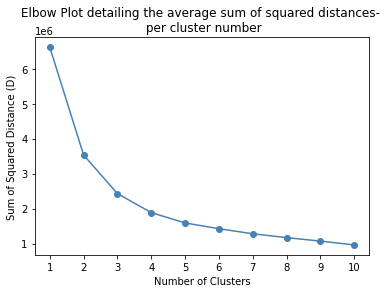

In [41]:
plt.plot(range(1, 11), D, color='steelblue')
plt.scatter(range(1, 11), D, color='steelblue')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distance (D)")
plt.title("Elbow Plot detailing the average sum of squared distances- \n per cluster number")
plt.show()

In [42]:
kn = KneeLocator(x= list(range(1,11)), y=D, curve='convex', direction='decreasing')
print(round(kn.knee, 3))
print(round(kn.elbow, 3))

3
3


In [43]:
# Same paramaters as before
kmeans_kwargs = {
       "init": "k-means++",
       "n_init": 10,
        "max_iter": 3000,
        "random_state": 42,
        }

kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
cluster_labels = kmeans.fit_predict(X_train_scaled)

In [69]:
cust_sum['cluster']= cluster_labels

In [71]:
cust_sum.head()

,customerkey,orders,total_unitssold,total_grosssales,days_bw_orders,ASP,loyaltyaccount,gender,shipcountry,postcode,latitude,longitude,category,divisioncode,productgroup,brandcode,class,cluster
0,50b8a1ad59263795e4b86653238c3e9f811ea9ea,1,2,119.83,1825,59.92,Yes,female,United Kingdom,DD4,56.4820,-2.940783,Mens,APPAREL,Suits,NN,0,0
1,7a6b4ee69910d9e46f43a620fbf68dcf893289c6,1,3,453.43,1825,151.14,No,male,United Kingdom,KY1,56.1667,-3.121411,Mens,FOOTWEAR,Nylon Running,NN,0,0
2,5d02e129a77da51d3b1c86e7818cc138da4db1f3,1,1,88.85,1825,88.85,No,female,United Kingdom,CH2,53.2386,-2.859610,Mens,FOOTWEAR,Nylon Running,NN,0,0
3,4fb0f728123a1f25d11d6994f92a92106caa6d9a,1,2,72.90,1825,36.45,No,female,United Kingdom,NG24,53.0500,-0.785257,Womens,FOOTWEAR,Vulcanised,VV,0,0
4,0b15db77fc71c5c87277b7851ef54698eadc997c,3,12,331.25,365,27.60,No,female,United Kingdom,KW8,58.1263,-3.668281,Junior,FOOTWEAR,Non-retail Items,AA,2,2


In [49]:
cust_sum['clu'].value_counts()

0    1935848
2     245926
1      23099
Name: class, dtype: int64

In [50]:
cust_sum['class'].value_counts(normalize=True)

0    0.877986
2    0.111537
1    0.010476
Name: class, dtype: float64

In [53]:
clust = cust_sum.groupby(
   ['class']
).agg(
    {
         'orders':"mean",
        'total_unitssold':"mean",
        'total_grosssales':"mean"
    }
).round(decimals=2)
clust= clust.reset_index()
clust

,class,orders,total_unitssold,total_grosssales
0,0,1.19,3.43,134.68
1,1,8.74,44.86,1635.21
2,2,3.35,13.50,516.96


In [55]:
cust_sum.to_csv('cust_summary_clustered.csv')

In [56]:
cust_sum.head()

,customerkey,orders,total_unitssold,total_grosssales,days_bw_orders,ASP,loyaltyaccount,gender,shipcountry,postcode,latitude,longitude,category,divisioncode,productgroup,brandcode,class
0,50b8a1ad59263795e4b86653238c3e9f811ea9ea,1,2,119.83,1825,59.92,Yes,female,United Kingdom,DD4,56.4820,-2.940783,Mens,APPAREL,Suits,NN,0
1,7a6b4ee69910d9e46f43a620fbf68dcf893289c6,1,3,453.43,1825,151.14,No,male,United Kingdom,KY1,56.1667,-3.121411,Mens,FOOTWEAR,Nylon Running,NN,0
2,5d02e129a77da51d3b1c86e7818cc138da4db1f3,1,1,88.85,1825,88.85,No,female,United Kingdom,CH2,53.2386,-2.859610,Mens,FOOTWEAR,Nylon Running,NN,0
3,4fb0f728123a1f25d11d6994f92a92106caa6d9a,1,2,72.90,1825,36.45,No,female,United Kingdom,NG24,53.0500,-0.785257,Womens,FOOTWEAR,Vulcanised,VV,0
4,0b15db77fc71c5c87277b7851ef54698eadc997c,3,12,331.25,365,27.60,No,female,United Kingdom,KW8,58.1263,-3.668281,Junior,FOOTWEAR,Non-retail Items,AA,2


In [72]:
retail = cust_sum[['ASP','loyaltyaccount','gender','shipcountry','category','divisioncode','cluster']]

In [73]:
#categorical data
categorical_cols = ['loyaltyaccount','gender','shipcountry','category','divisioncode'] 

#import pandas as pd
retail = pd.get_dummies(retail, columns = categorical_cols)

In [74]:
retail.head()

,ASP,cluster,loyaltyaccount_No,loyaltyaccount_Yes,gender_female,gender_male,gender_unknown,shipcountry_Albania,shipcountry_Armenia,shipcountry_Australia,...,category_Childrens,category_Infant,category_Junior,category_Mens,category_Miscellaneous,category_Nursery,category_Womens,divisioncode_ACCESSORY,divisioncode_APPAREL,divisioncode_FOOTWEAR
0,59.92,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,151.14,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,88.85,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,36.45,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,27.60,2,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [64]:
retail.shape

(2204873, 85)

In [76]:
retail.to_csv('cust_summary_clustered.csv')

In [75]:
# Cust Summary focusing on singular minority
cust_sum = deepcopy(retail)
cust_sum.loc[cust_sum.cluster <= 1, "class"] = 0
cust_sum.loc[cust_sum.cluster == 2, "class"] = 1
cust_sum['class'] = cust_sum['class'].astype("int")
cust_sum['class'] = cust_sum['class'].astype("category")
print(cust_sum['class'].value_counts())
cust_sum.name ='Retail Data -1'

0    1958947
1     245926
Name: class, dtype: int64
